In [42]:
pip install xgboost

In [43]:
import xgboost
print("xgboost", xgboost.__version__)

xgboost 3.0.4


In [44]:
from re import X
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

try:
    df = pd.read_csv('final_ml_data.csv')
    print("Succesfully loaded dataset")
    print(f"Dataset shape: {df.shape}")
    print("Dataset columns:", df.columns.tolist()) # Added line to print columns
except Exception as e:
    print(f"Error loading dataset: {e}")

X = df.drop('Winner_target', axis=1)
y = df['Winner_target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {y_train.shape[0]} samples")

Succesfully loaded dataset
Dataset shape: (4828, 84)
Dataset columns: ['R_KD', 'B_KD', 'R_SUB_ATT', 'B_SUB_ATT', 'R_REV', 'B_REV', 'last_round', 'SLpM_x', 'SApM_x', 'TD_Avg_x', 'Sub_Avg_x', 'R_Height_cms', 'R_Weight_lbs', 'R_Reach_cms', 'SLpM_y', 'SApM_y', 'TD_Avg_y', 'Sub_Avg_y', 'B_Height_cms', 'B_Weight_lbs', 'B_Reach_cms', 'R_SIG_STR_landed', 'R_SIG_STR_attempted', 'B_SIG_STR_landed', 'B_SIG_STR_attempted', 'R_TOTAL_STR_landed', 'R_TOTAL_STR_attempted', 'B_TOTAL_STR_landed', 'B_TOTAL_STR_attempted', 'R_TD_landed', 'R_TD_attempted', 'B_TD_landed', 'B_TD_attempted', 'R_HEAD_landed', 'R_HEAD_attempted', 'B_HEAD_landed', 'B_HEAD_attempted', 'R_BODY_landed', 'R_BODY_attempted', 'B_BODY_landed', 'B_BODY_attempted', 'R_LEG_landed', 'R_LEG_attempted', 'B_LEG_landed', 'B_LEG_attempted', 'R_DISTANCE_landed', 'R_DISTANCE_attempted', 'B_DISTANCE_landed', 'B_DISTANCE_attempted', 'R_CLINCH_landed', 'R_CLINCH_attempted', 'B_CLINCH_landed', 'B_CLINCH_attempted', 'R_GROUND_landed', 'R_GROUND_attemp

In [45]:
# Difference features for columns present in df
features_to_diff_present = {
    'height': ('R_Height_cms', 'B_Height_cms'),
    'reach': ('R_Reach_cms', 'B_Reach_cms'),
    'weight': ('R_Weight_lbs', 'B_Weight_lbs'),
    'slpm': ('SLpM_x', 'SLpM_y'),
    'str_acc': ('Str_Acc_x_float', 'Str_Acc_y_float'),
    'sapm': ('SApM_x', 'SApM_y'),
    'str_def': ('Str_Def_x_float', 'Str_Def_y_float'),
    'td_avg': ('TD_Avg_x', 'TD_Avg_y'),
    'td_acc': ('TD_Acc_x_float', 'TD_Acc_y_float'),
    'td_def': ('TD_Def_x_float', 'TD_Def_y_float'),
    'sub_avg': ('Sub_Avg_x', 'Sub_Avg_y')
}

diff_df = df.copy()

for name, (r_col, b_col) in features_to_diff_present.items():
    if r_col in diff_df.columns and b_col in diff_df.columns:
        diff_df[f'{name}_diff'] = diff_df[r_col] - diff_df[b_col]
    else:
        print(f"Warning: Columns {r_col} or {b_col} not found for {name}_diff calculation.")

final_df = diff_df.select_dtypes(include=[np.number]).fillna(0)


--- Top 20 Features Most Positively Correlated with a Win ---
Winner_target            1.000000
R_GROUND_landed          0.319018
R_GROUND_attempted       0.316954
R_SIG_STR_pct_float      0.306014
R_KD                     0.279846
R_TOTAL_STR_landed       0.265607
R_TD_pct_float           0.238062
R_HEAD_landed            0.227755
R_TD_landed              0.223836
slpm_diff                0.207822
R_SIG_STR_landed         0.199092
R_SUB_ATT                0.176492
R_TOTAL_STR_attempted    0.169211
td_def_diff              0.166066
str_acc_diff             0.158517
str_def_diff             0.155995
R_CLINCH_landed          0.132252
R_CLINCH_attempted       0.124365
Str_Def_x_float          0.120699
Str_Acc_x_float          0.102875
Name: Winner_target, dtype: float64

--- Top 20 Features Most Negatively Correlated with a Win (i.e., Correlated with a Loss) ---
TD_Def_y_float          -0.142844
R_age                   -0.143386
SApM_x                  -0.147434
sapm_diff               -

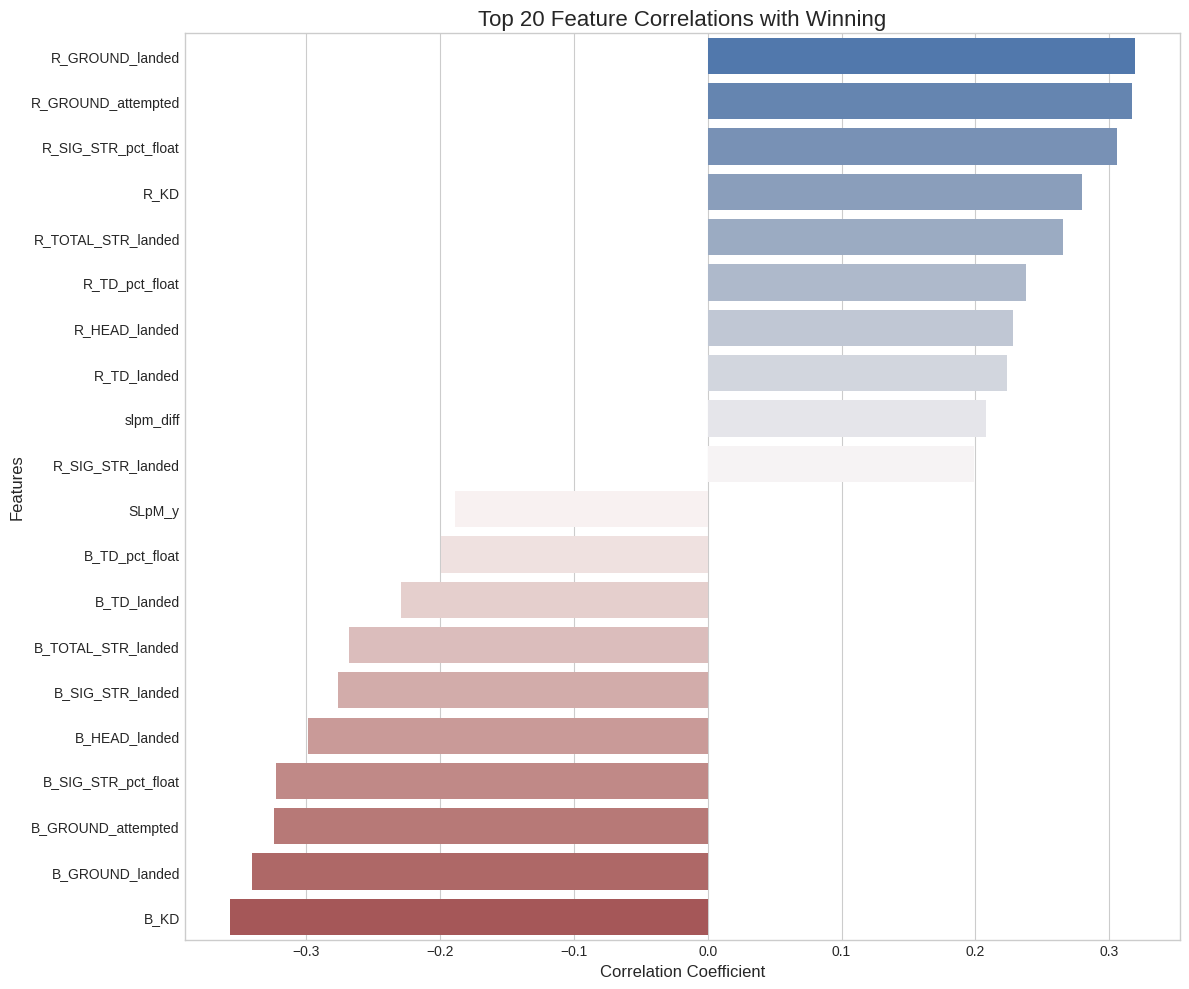

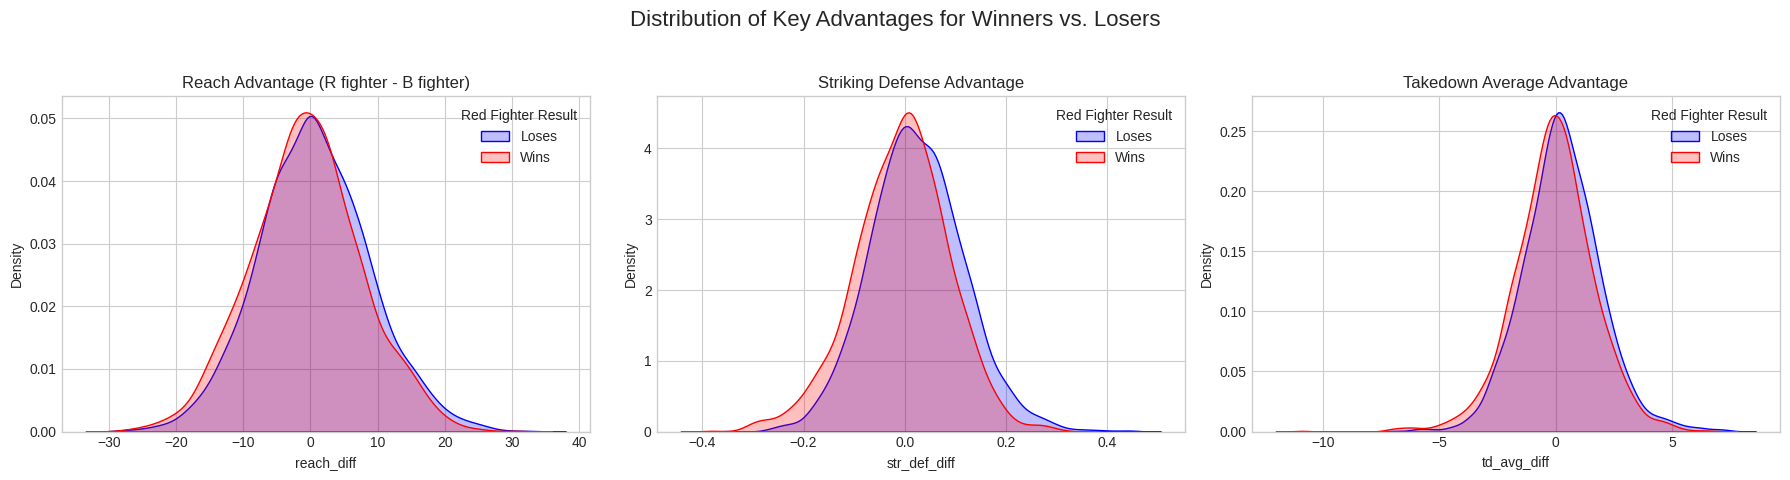

In [46]:
# --- Feature Importance and Visualization ---

# Check if 'Winner_target' column exists before proceeding
if 'Winner_target' in final_df.columns:
    # 1. Calculate Correlation with the Target Variable
    # This tells us which features are most predictive of a win for the Red fighter
    correlation_matrix = final_df.corr(numeric_only=True) # Added numeric_only=True for potential non-numeric columns
    winner_correlation = correlation_matrix['Winner_target'].sort_values(ascending=False)

    print("\n--- Top 20 Features Most Positively Correlated with a Win ---")
    print(winner_correlation.head(20))

    print("\n--- Top 20 Features Most Negatively Correlated with a Win (i.e., Correlated with a Loss) ---")
    print(winner_correlation.tail(20))


    # 2. Visualize Feature Importance
    plt.style.use('seaborn-v0_8-whitegrid')
    # We select the top 10 positive and top 10 negative to get a balanced view
    # Exclude the correlation of Winner_target with itself
    top_features = pd.concat([winner_correlation.drop('Winner_target').head(10), winner_correlation.tail(10)])


    plt.figure(figsize=(12, 10))
    # Fine-tuned barplot call to address FutureWarning
    sns.barplot(x=top_features.values, y=top_features.index, palette="vlag", hue=top_features.index, legend=False)
    plt.title('Top 20 Feature Correlations with Winning', fontsize=16)
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.savefig("feature_correlations.png")
    print("\nGenerated 'feature_correlations.png'")


    # 3. Visualize Key Feature Distributions
    # Check if the key difference features exist before plotting distributions
    key_diff_features = ['reach_diff', 'str_def_diff', 'td_avg_diff']
    if all(feature in final_df.columns for feature in key_diff_features):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Distribution of Key Advantages for Winners vs. Losers', fontsize=16)

        # Plot for Reach Difference
        sns.kdeplot(data=final_df, x='reach_diff', hue='Winner_target', fill=True,
                    palette={0: "red", 1: "blue"}, ax=axes[0], common_norm=False)
        axes[0].set_title('Reach Advantage (R fighter - B fighter)')
        axes[0].legend(title='Red Fighter Result', labels=['Loses', 'Wins'])

        # Plot for Striking Defense Difference
        sns.kdeplot(data=final_df, x='str_def_diff', hue='Winner_target', fill=True,
                    palette={0: "red", 1: "blue"}, ax=axes[1], common_norm=False)
        axes[1].set_title('Striking Defense Advantage')
        axes[1].legend(title='Red Fighter Result', labels=['Loses', 'Wins'])

        # Plot for Takedown Average Difference
        sns.kdeplot(data=final_df, x='td_avg_diff', hue='Winner_target', fill=True,
                    palette={0: "red", 1: "blue"}, ax=axes[2], common_norm=False)
        axes[2].set_title('Takedown Average Advantage')
        axes[2].legend(title='Red Fighter Result', labels=['Loses', 'Wins'])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig("feature_distributions.png")
        print("Generated 'feature_distributions.png'")
    else:
        print("\nSkipping distribution plots: One or more key difference features ('reach_diff', 'str_def_diff', 'td_avg_diff') not found in the DataFrame.")

else:
    print("Error: 'Winner_target' column not found in the DataFrame. Cannot perform correlation analysis and visualization.")

In [47]:
X = df.drop('Winner_target', axis=1)
y = df['Winner_target']

# Initialize and train the XGBoost Classifier
print("\nInitializing XGBoost model...")

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    # Removed device='tpu' as it is not a supported device option
    eval_metric='logloss',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    use_label_encoder=False # Keep use_label_encoder=False as recommended for recent XGBoost versions
)

print("Training the model...")
xgb_clf.fit(X_train, y_train)
print("Model training complete.")

print("\n--- Model Evaluation on Unseen Data ---")
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Blue Wins (0)', 'Red Wins (1)']))


Initializing XGBoost model...
Training the model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:10:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Model Evaluation on Unseen Data ---
Model Accuracy: 88.41%

Classification Report:
               precision    recall  f1-score   support

Blue Wins (0)       0.87      0.81      0.84       356
 Red Wins (1)       0.89      0.93      0.91       610

     accuracy                           0.88       966
    macro avg       0.88      0.87      0.87       966
 weighted avg       0.88      0.88      0.88       966



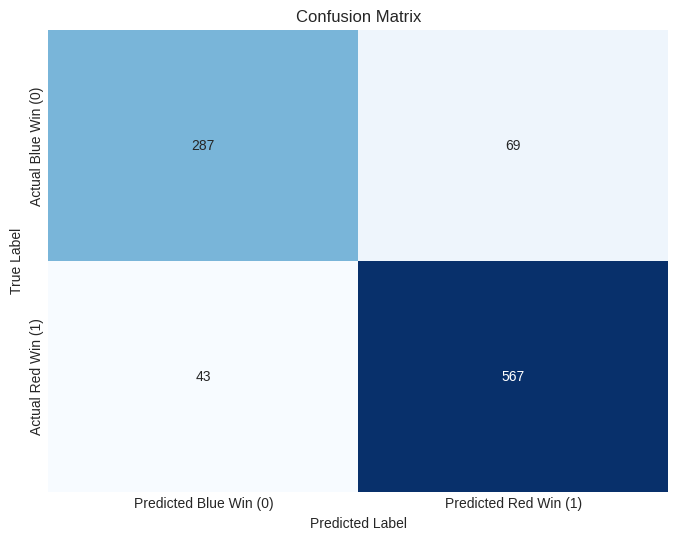

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Blue Win (0)', 'Predicted Red Win (1)'],
            yticklabels=['Actual Blue Win (0)', 'Actual Red Win (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

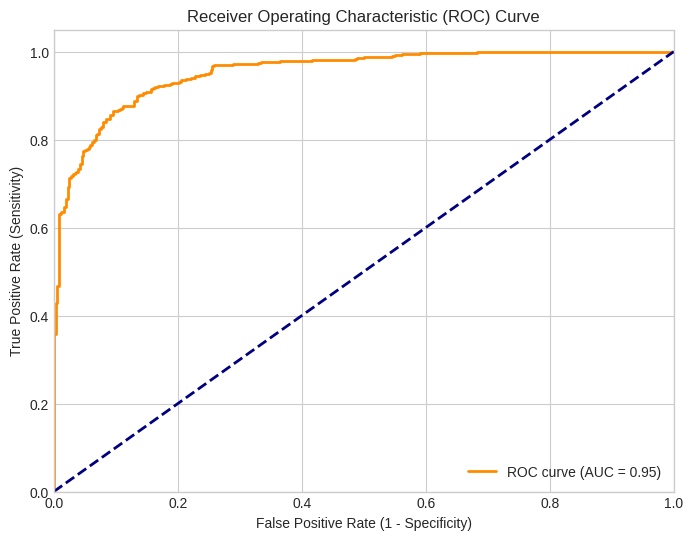


Area Under the ROC Curve (AUC): 0.9538


In [49]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class (Red Win = 1)
# The predict_proba method returns probabilities for both classes [prob_class_0, prob_class_1]
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Plot the random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nArea Under the ROC Curve (AUC): {roc_auc:.4f}")

In [50]:
import joblib

# Save the model to a file
joblib.dump(xgb_clf, 'ufc_winner_predictor_model.joblib')

print("Model saved successfully!")

Model saved successfully!


In [51]:
fighter_details_df = pd.read_csv('raw_fighter_details.csv')
fighter_names_list = fighter_details_df['fighter_name'].unique().tolist()

In [52]:
import pandas as pd
import joblib
from datetime import datetime
import numpy as np

# --- 1. Load the Saved Model and Required Data ---

try:
    # Load the trained model
    model = joblib.load('ufc_winner_predictor_model.joblib')
    print("Model 'ufc_winner_predictor_model.joblib' loaded successfully.")

    # Load the fighter stats. This file is our "database" of fighters.
    fighter_stats_df = pd.read_csv('raw_fighter_details.csv')
    print("Fighter details loaded successfully.")

    # Load the final data file *only* to get the exact column order the model was trained on
    final_model_data = pd.read_csv('final_ml_data.csv')
    # Exclude the target variable to get the list of feature columns
    model_feature_columns = final_model_data.columns.drop('Winner_target').tolist()
    print(f"Model expects {len(model_feature_columns)} feature columns.")

except FileNotFoundError as e:
    print(f"Error loading a required file: {e}")
    print("Please ensure all necessary files ('ufc_winner_predictor_model.joblib', 'raw_fighter_details.csv', 'final_ml_data.csv') are uploaded.")
    # To prevent further errors, we can raise the exception or exit
    raise # Re-raise the exception after printing the message

# --- 2. Clean and Prepare Fighter Stats DataFrame ---
# (Using the same functions as before to handle height, reach, etc.)

def convert_height_to_cm(height_str):
    if isinstance(height_str, str) and "'" in height_str:
        feet, inches = height_str.split("'")
        inches = inches.replace('"', '').strip()
        try:
            total_inches = int(feet) * 12 + int(inches)
            return total_inches * 2.54
        except ValueError:
            return np.nan # Handle cases where inches is not a valid number
    return np.nan # Handle non-string inputs

def convert_percentage_to_float(pct_str):
    if isinstance(pct_str, str):
        try:
            return float(pct_str.replace('%', '').strip()) / 100.0
        except ValueError:
            return np.nan # Handle cases where percentage string is not valid
    return np.nan # Handle non-string inputs

# Apply cleaning functions
fighter_stats_df['Height_cms'] = fighter_stats_df['Height'].apply(convert_height_to_cm)
# Ensure 'Reach' column is treated as string before replace
fighter_stats_df['Reach_cms'] = fighter_stats_df['Reach'].apply(lambda x: float(str(x).replace('"', '').strip()) * 2.54 if pd.notna(x) and isinstance(x, str) and '"' in str(x) else np.nan)
fighter_stats_df['DOB'] = pd.to_datetime(fighter_stats_df['DOB'], errors='coerce')

# Ensure these columns exist and are strings before applying percentage conversion
for col in ['Str_Acc', 'Str_Def', 'TD_Acc', 'TD_Def']:
    if col in fighter_stats_df.columns:
        fighter_stats_df[f'{col}_float'] = fighter_stats_df[col].apply(convert_percentage_to_float)
    else:
         fighter_stats_df[f'{col}_float'] = np.nan # Create the column with NaN if original is missing


# Ensure numeric columns used in prediction are numeric, coerce errors to NaN
numeric_cols_to_use = ['KD', 'SUB_ATT', 'REV', 'SLpM', 'SApM', 'TD_Avg', 'Sub_Avg',
                       'Height_cms', 'Weight', 'Reach_cms',
                       'Str_Acc_float', 'Str_Def_float', 'TD_Acc_float', 'TD_Def_float']

for col in numeric_cols_to_use:
    if col in fighter_stats_df.columns:
        # Attempt to convert 'Weight' which might have 'lbs.'
        if col == 'Weight':
             # Use pd.to_numeric with errors='coerce' for robustness
             fighter_stats_df['Weight_lbs'] = pd.to_numeric(fighter_stats_df['Weight'].astype(str).str.replace(' lbs.', '', regex=False), errors='coerce')
        else:
            fighter_stats_df[col] = pd.to_numeric(fighter_stats_df[col], errors='coerce')
    else:
         # If a required column is missing, print a warning and create it with NaNs
        print(f"Warning: Column '{col}' not found in raw_fighter_details.csv.")
        if col == 'Weight':
             fighter_stats_df['Weight_lbs'] = np.nan
        else:
            fighter_stats_df[col] = np.nan


# Drop the original non-numeric 'Weight' column after creating 'Weight_lbs'
if 'Weight' in fighter_stats_df.columns:
    fighter_stats_df = fighter_stats_df.drop('Weight', axis=1)


print("Fighter details cleaned and prepared.")


# --- 3. The Prediction Function ---

def predict_fight_outcome(fighter_a_name, fighter_b_name, stats_df, model, feature_columns):
    """
    Predicts the win probability for a fight between two fighters.

    Args:
        fighter_a_name (str): Name of the first fighter (Red Corner).
        fighter_b_name (str): Name of the second fighter (Blue Corner).
        stats_df (pd.DataFrame): DataFrame containing all fighter stats (cleaned).
        model: The trained machine learning model.
        feature_columns (list): The exact list of feature names the model was trained on.

    Returns:
        str: A formatted string with the prediction probabilities.
        or None: If an error occurs (e.g., fighter not found).
    """
    try:
        # Look up stats for both fighters
        fighter_a_stats = stats_df[stats_df['fighter_name'].str.lower() == fighter_a_name.lower()].iloc[0]
        fighter_b_stats = stats_df[stats_df['fighter_name'].str.lower() == fighter_b_name.lower()].iloc[0]
        print(f"Found stats for {fighter_a_name} and {fighter_b_name}.")
    except IndexError:
        print(f"Error: Could not find stats for one or both fighters ({fighter_a_name}, {fighter_b_name}) in the dataset.")
        return None # Return None or raise an error to indicate failure

    # --- NEW: Add a weight class sanity check ---
    weight_a = fighter_a_stats.get('Weight_lbs', np.nan) # Use .get for robustness
    weight_b = fighter_b_stats.get('Weight_lbs', np.nan) # Use .get for robustness

    # Check if weights are available before calculating difference
    if pd.notna(weight_a) and pd.notna(weight_b):
        # If the weight difference is more than 20 lbs, the matchup is invalid.
        if abs(weight_a - weight_b) > 20:
            return (f"--- Prediction Invalid ---\n"
                    f"{fighter_a_name} ({weight_a} lbs) and {fighter_b_name} ({weight_b} lbs) "
                    f"are not in a comparable weight class.")
    else:
        # Handle case where weight data is missing for one or both fighters
        print("Warning: Weight data is missing for one or both fighters. Skipping weight class check.")


    # --- Create a dictionary of features for this specific matchup ---
    prediction_data = {}

    # Calculate current age for both fighters
    today = datetime.now()
    # Use integer division for age in years
    fighter_a_age = (today - fighter_a_stats['DOB']).days // 365.25 if pd.notna(fighter_a_stats['DOB']) else np.nan
    fighter_b_age = (today - fighter_b_stats['DOB']).days // 365.25 if pd.notna(fighter_b_stats['DOB']) else np.nan


    # Explicitly populate prediction_data based on feature_columns and available fighter stats
    for col in feature_columns:
        if col.endswith('_diff'):
            base_name = col.replace('_diff', '')
            if base_name == 'age':
                 prediction_data[col] = fighter_a_age - fighter_b_age if pd.notna(fighter_a_age) and pd.notna(fighter_b_age) else np.nan
            elif base_name == 'height':
                 prediction_data[col] = fighter_a_stats.get('Height_cms') - fighter_b_stats.get('Height_cms') if pd.notna(fighter_a_stats.get('Height_cms')) and pd.notna(fighter_b_stats.get('Height_cms')) else np.nan
            elif base_name == 'reach':
                 prediction_data[col] = fighter_a_stats.get('Reach_cms') - fighter_b_stats.get('Reach_cms') if pd.notna(fighter_a_stats.get('Reach_cms')) and pd.notna(fighter_b_stats.get('Reach_cms')) else np.nan
            elif base_name == 'weight':
                 prediction_data[col] = fighter_a_stats.get('Weight_lbs') - fighter_b_stats.get('Weight_lbs') if pd.notna(fighter_a_stats.get('Weight_lbs')) and pd.notna(fighter_b_stats.get('Weight_lbs')) else np.nan
            elif base_name == 'slpm':
                 prediction_data[col] = fighter_a_stats.get('SLpM') - fighter_b_stats.get('SLpM') if pd.notna(fighter_a_stats.get('SLpM')) and pd.notna(fighter_b_stats.get('SLpM')) else np.nan
            elif base_name == 'str_acc':
                 prediction_data[col] = fighter_a_stats.get('Str_Acc_float') - fighter_b_stats.get('Str_Acc_float') if pd.notna(fighter_a_stats.get('Str_Acc_float')) and pd.notna(fighter_b_stats.get('Str_Acc_float')) else np.nan
            elif base_name == 'sapm':
                 prediction_data[col] = fighter_a_stats.get('SApM') - fighter_b_stats.get('SApM') if pd.notna(fighter_a_stats.get('SApM')) and pd.notna(fighter_b_stats.get('SApM')) else np.nan
            elif base_name == 'str_def':
                 prediction_data[col] = fighter_a_stats.get('Str_Def_float') - fighter_b_stats.get('Str_Def_float') if pd.notna(fighter_a_stats.get('Str_Def_float')) and pd.notna(fighter_b_stats.get('Str_Def_float')) else np.nan
            elif base_name == 'td_avg':
                 prediction_data[col] = fighter_a_stats.get('TD_Avg') - fighter_b_stats.get('TD_Avg') if pd.notna(fighter_a_stats.get('TD_Avg')) and pd.notna(fighter_b_stats.get('TD_Avg')) else np.nan
            elif base_name == 'td_acc':
                 prediction_data[col] = fighter_a_stats.get('TD_Acc_float') - fighter_b_stats.get('TD_Acc_float') if pd.notna(fighter_a_stats.get('TD_Acc_float')) and pd.notna(fighter_b_stats.get('TD_Acc_float')) else np.nan
            elif base_name == 'td_def':
                 prediction_data[col] = fighter_a_stats.get('TD_Def_float') - fighter_b_stats.get('TD_Def_float') if pd.notna(fighter_a_stats.get('TD_Def_float')) and pd.notna(fighter_b_stats.get('TD_Def_float')) else np.nan
            elif base_name == 'sub_avg':
                 prediction_data[col] = fighter_a_stats.get('Sub_Avg') - fighter_b_stats.get('Sub_Avg') if pd.notna(fighter_a_stats.get('Sub_Avg')) and pd.notna(fighter_b_stats.get('Sub_Avg')) else np.nan
            else:
                 prediction_data[col] = np.nan # Should not happen if feature_columns are only diffs or R_/B_ prefixes

        elif col.startswith('R_'):
            raw_col_name = col[2:] # Remove 'R_' prefix
            if raw_col_name == 'age':
                 prediction_data[col] = fighter_a_age
            # Use .get() with a default of np.nan to handle missing columns gracefully
            elif raw_col_name == 'Weight_lbs':
                 prediction_data[col] = fighter_a_stats.get('Weight_lbs', np.nan)
            elif raw_col_name.endswith('_float'):
                 prediction_data[col] = fighter_a_stats.get(raw_col_name, np.nan)
            else:
                 # Handle other raw stats directly from fighter_a_stats (e.g., KD, SUB_ATT, REV)
                 # Use .get() for robustness in case columns are missing in fighter_stats_df
                 prediction_data[col] = fighter_a_stats.get(raw_col_name, np.nan)


        elif col.startswith('B_'):
            raw_col_name = col[2:] # Remove 'B_' prefix
            if raw_col_name == 'age':
                 prediction_data[col] = fighter_b_age
            # Use .get() with a default of np.nan to handle missing columns gracefully
            elif raw_col_name == 'Weight_lbs':
                 prediction_data[col] = fighter_b_stats.get('Weight_lbs', np.nan)
            elif raw_col_name.endswith('_float'):
                 prediction_data[col] = fighter_b_stats.get(raw_col_name, np.nan)
            else:
                 # Handle other raw stats directly from fighter_b_stats (e.g., KD, SUB_ATT, REV)
                 # Use .get() for robustness
                 prediction_data[col] = fighter_b_stats.get(raw_col_name, np.nan)

        # Handle columns without R_ or B_ prefixes or _diff suffixes (like 'last_round')
        else:
             # Assuming these columns exist directly in the final_model_data but
             # cannot be derived from individual fighter stats.
             # For a prediction on a single fight, their value would need to be known.
             # We'll fill with 0 or a sensible default if they are in feature_columns
             # but not derivable from fighter_stats_df.
             # Based on the original df columns, 'last_round' exists. We will fill it with 0
             # as we cannot derive it from raw_fighter_details.csv
             if col in final_model_data.columns: # Check if the column exists in the original training data structure
                prediction_data[col] = 0 # Fill with a default (e.g., 0)
             else:
                 print(f"Warning: Feature column '{col}' is in model_feature_columns but its value cannot be determined from fighter stats or defaults.")
                 prediction_data[col] = np.nan # Cannot derive value


    # Convert the dictionary to a single-row DataFrame
    # Ensure the column order is exactly the same as the training data
    # Create DataFrame from the dictionary
    prediction_df = pd.DataFrame([prediction_data])

    # Reindex to ensure the correct column order, adding missing columns as NaN if any
    prediction_df = prediction_df.reindex(columns=feature_columns)

    # Fill any potential missing values with 0, consistent with final_df processing
    prediction_df.fillna(0, inplace=True)

    # Debugging: Check the generated prediction_df
    # print("\nGenerated prediction_df:")
    # print(prediction_df)


    # --- Make the prediction ---
    # Use .predict_proba() to get the probabilities
    probabilities = model.predict_proba(prediction_df)[0]

    prob_b_wins = probabilities[0]
    prob_a_wins = probabilities[1]

    # --- Format and return the output ---
    result = (
        f"--- Prediction for {fighter_a_name} vs. {fighter_b_name} ---\n"
        f"Win Probability for {fighter_a_name}: {prob_a_wins:.2%}\n"
        f"Win Probability for {fighter_b_name}: {prob_b_wins:.2%}"
    )

    return result


# --- 4. Example Usage ---

# Pick two fighters from your dataset
fighter1 = "Israel Adesanya" # Red Corner
fighter2 = "Alex Pereira"   # Blue Corner

# Get the prediction
prediction_result = predict_fight_outcome(fighter1, fighter2, fighter_stats_df, model, model_feature_columns)
if prediction_result:
    print(prediction_result)

print("\n")

# Another example
fighter1 = "Jon Jones"    # Red Corner
fighter2 = "Khabib Nurmagomedov" # Blue Corner

prediction_result = predict_fight_outcome(fighter1, fighter2, fighter_stats_df, model, model_feature_columns)
if prediction_result:
    print(prediction_result)

print("\n")

Model 'ufc_winner_predictor_model.joblib' loaded successfully.
Fighter details loaded successfully.
Model expects 83 feature columns.
Fighter details cleaned and prepared.
Found stats for Israel Adesanya and Alex Pereira.
--- Prediction for Israel Adesanya vs. Alex Pereira ---
Win Probability for Israel Adesanya: 26.07%
Win Probability for Alex Pereira: 73.93%


Found stats for Jon Jones and Khabib Nurmagomedov.
--- Prediction Invalid ---
Jon Jones (205.0 lbs) and Khabib Nurmagomedov (155.0 lbs) are not in a comparable weight class.




In [57]:
from IPython.display import display, clear_output
import ipywidgets as widgets

try:
    fighter_details_df = pd.read_csv('raw_fighter_details.csv')
    fighter_names_list = sorted(fighter_details_df['fighter_name'].unique().tolist()) # Sort the list for easier navigation
except FileNotFoundError:
    print("Error: 'raw_fighter_details.csv' not found. Cannot populate fighter dropdowns.")
    fighter_names_list = [] # Provide an empty list to avoid errors

# comboboxes for selecting fighters (allows typing and suggestions)
red_fighter_combobox = widgets.Combobox(
    options=fighter_names_list,
    description='Red Gloves:',
    ensure_option=True,
    disabled=False,
)

blue_fighter_combobox = widgets.Combobox(
    options=fighter_names_list,
    description='Blue Gloves:',
    ensure_option=True,
    disabled=False,
)

# Create a button to trigger the prediction
predict_button = widgets.Button(
    description='Predict Outcome',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict the fight outcome',
    icon='futbol' # (FontAwesome icons available: https://fontawesome.com/v4/icons/)
)

# Create an output widget to display results
output_area = widgets.Output()


# --- Step 3: Define prediction display function ---
def on_predict_button_clicked(b):
    """Handles the button click event to trigger the fight prediction."""
    with output_area: # Direct output to the output_area widget
        clear_output(wait=True) # Clear previous output

        # Get values from comboboxes
        red_fighter = red_fighter_combobox.value
        blue_fighter = blue_fighter_combobox.value

        if red_fighter == blue_fighter:
            print("Error: Please select two different fighters.")
            return
        if not red_fighter or not blue_fighter:
             print("Error: Please select both fighters.")
             return
        if not fighter_names_list:
            print("Error: Fighter names list is empty. Cannot perform prediction.")
            return

        # Check if selected names are actually in the list (important with Combobox)
        if red_fighter not in fighter_names_list:
             print(f"Error: '{red_fighter}' not found in the fighter list. Please select a valid fighter.")
             return
        if blue_fighter not in fighter_names_list:
             print(f"Error: '{blue_fighter}' not found in the fighter list. Please select a valid fighter.")
             return


        print(f"Predicting fight between {red_fighter} (Red) and {blue_fighter} (Blue)...")

        try:
            prediction_result = predict_fight_outcome(red_fighter, blue_fighter, fighter_stats_df, model, model_feature_columns)

            if prediction_result:
                print(prediction_result)
            else:
                print("Error: Prediction function returned None.")
                pass
        except NameError as e:
             print(f"Error: Required variables (model, fighter_stats_df, model_feature_columns) are not defined. Please run the previous cells first. Details: {e}")
        except Exception as e:
             print(f"An unexpected error occurred during prediction: {e}")

# Link the button click event to the function
predict_button.on_click(on_predict_button_clicked)

# display
print("Please select the fighters:")
display(red_fighter_combobox)
display(blue_fighter_combobox)
display(predict_button)
display(output_area)

Please select the fighters:


Combobox(value='', description='Red Gloves:', ensure_option=True, options=('AJ Fonseca', 'AJ Matthews', 'AJ Mc…

Combobox(value='', description='Blue Gloves:', ensure_option=True, options=('AJ Fonseca', 'AJ Matthews', 'AJ M…

Button(description='Predict Outcome', icon='futbol', style=ButtonStyle(), tooltip='Click to predict the fight …

Output()

# **Implementing Meta-Elo System**